In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
df_train = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/test.csv')

#df_train_original = pd.read_csv('data/train.csv')

print(df_train.shape)
print(df_val.shape)     

(300000, 16)
(200000, 15)


In [3]:
df_train.head(3)

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091


In [4]:
df_train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,249825.145857,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483926,0.506877,0.553442,0.503713,7.905661
std,144476.732562,0.203976,0.228159,0.200770,0.233035,0.220701,0.217909,0.181096,0.216221,0.196685,0.201854,0.220082,0.218947,0.229730,0.208238,0.733071
min,1.000000,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367,0.000000
25%,124656.500000,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673,7.329367
50%,249738.500000,0.484005,0.553209,0.551471,0.482880,0.451733,0.470988,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845,7.940571
75%,374836.250000,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653,8.470084
max,499999.000000,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049025,0.977845,0.868506,10.267569


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['target'], axis=1),  # drop the target
    df_train['target'],  # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((240000, 15), (60000, 15))

In [6]:
### Baseline model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'RMSE: {rmse:.5f}')

RMSE: 0.72554


In [7]:
#### The next part is an example of features selection. 

#### 1. VarianceThreshold from Scikit-learn

In [8]:
sel = VarianceThreshold(threshold=0.0)
sel.fit(X_train)  # fit finds the features with zero variance
sel.get_support()
constant = X_train.columns[~sel.get_support()]
len(constant)

0

In [9]:
### only works with numerical
const_f = [feat for feat in X_train.columns if X_train[feat].std() == 0]
len(const_f)

0

In [10]:
### works also with categorical variables

In [11]:
constant_features = [feat for feat in X_train.columns if X_train[feat].nunique() == 1]
len(constant_features)

0

#### 2. Quasi-constant features

In [12]:
sel = VarianceThreshold(threshold=0.02)  
sel.fit(X_train)  # fit finds the features with low variance
quasi_constant = X_train.columns[~sel.get_support()]

len(quasi_constant)

0

#### 3. Duplicated features

We have a dataset with numerical features, so if two columns are equal the sum also will be identical. Let's check all sums, it'll be faster than comparing each element. 

In [13]:
dic_sum = df_train.sum().to_dict()
k_v_exchanged = {}
for key, val in dic_sum.items():
    if val not in k_v_exchanged:
        k_v_exchanged[val] = [key]
    else:
        k_v_exchanged[val].append(key)

In [14]:
max([len(v) for v in k_v_exchanged.values()])

1

#### 4. Correlation

<AxesSubplot:>

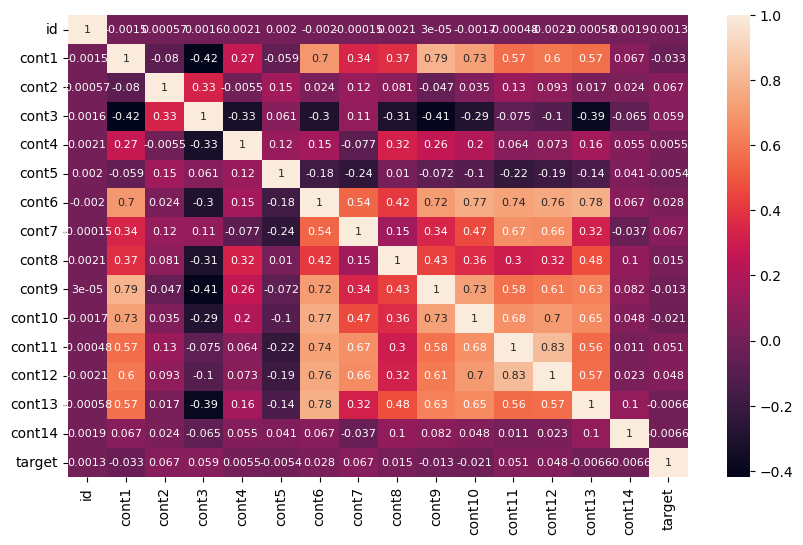

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(),annot=True, annot_kws={"size":8})
#sns.set(font_scale = .7)

In [16]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns    
    corr_matrix = dataset.corr()    
    for i in range(len(corr_matrix.columns)):    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [17]:
corr_features = correlation(X_train, 0.75)
print('correlated features: ', len(set(corr_features)) )

correlated features:  4


In [18]:
corr_features

{'cont10', 'cont12', 'cont13', 'cont9'}

In [19]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((240000, 11), (60000, 11))

In [20]:
### model
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'RMSE: {rmse:.5f}')
### So, with selected features RMSE a little bit increase

RMSE: 0.72721


#### 5. Mutual information

The mutual information measures the reduction in uncertainty in variable A when variable B is known.

In [21]:
from sklearn.feature_selection import mutual_info_regression

Text(0, 0.5, 'Mutual Information')

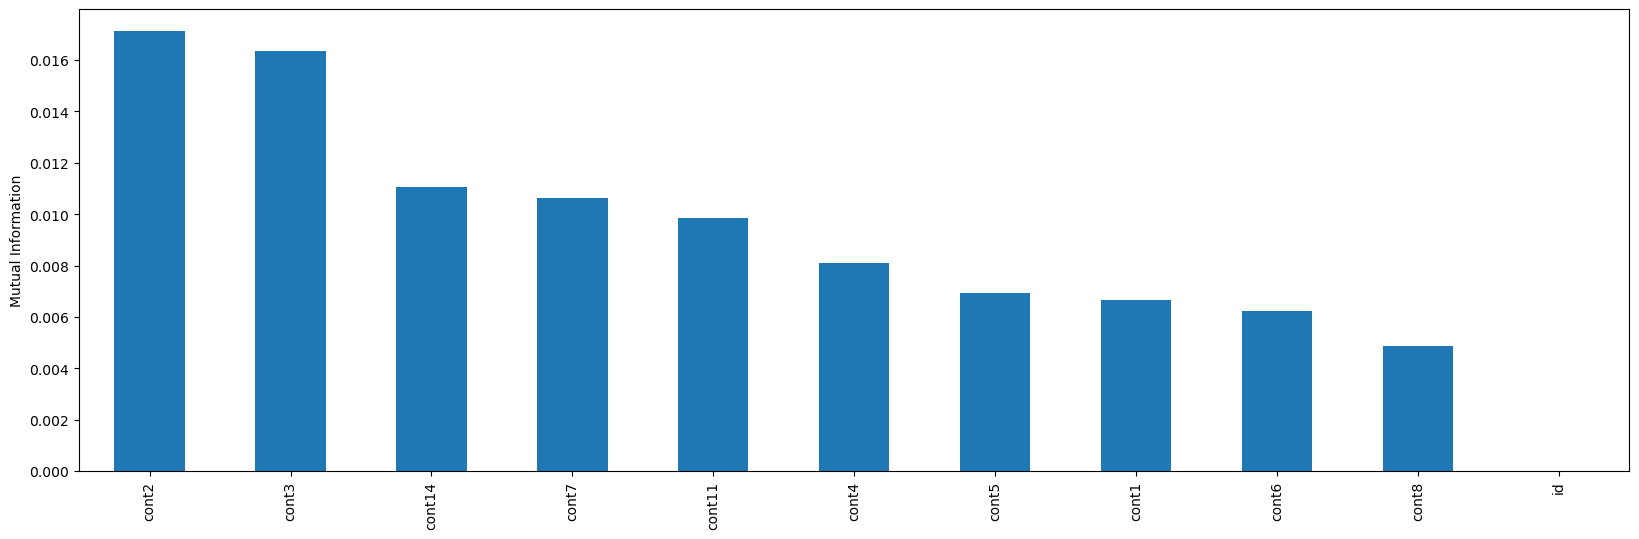

In [22]:
# determine the mutual information
mi = mutual_info_regression(X_train, y_train)

# and make a bar  plot
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

We can see, that the Id column is useless for prediction and there is no "dominant" feature in the data set.

In [23]:
mi_dict = dict(sorted(mi.to_dict().items(), key=lambda item: item[1]))

In [24]:
unmutal_cols = list(mi_dict.keys())[0]

In [25]:
X_train.drop(labels=unmutal_cols, axis=1, inplace=True)
X_test.drop(labels=unmutal_cols, axis=1, inplace=True)

X_train.shape, X_test.shape

((240000, 10), (60000, 10))

In [26]:
### model
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'RMSE: {rmse:.5f}')
### So, without the 'Id' feature RMSE doesn't change.

RMSE: 0.72720


#### 6. ANOVA

Univariate feature selection works by selecting the best features based on univariate statistical tests (ANOVA). The methods estimate the degree of linear dependency between two random variables. In this case, any of the predictor variables and the target.

In [27]:
## ANOVA
from sklearn.feature_selection import f_regression

<AxesSubplot:>

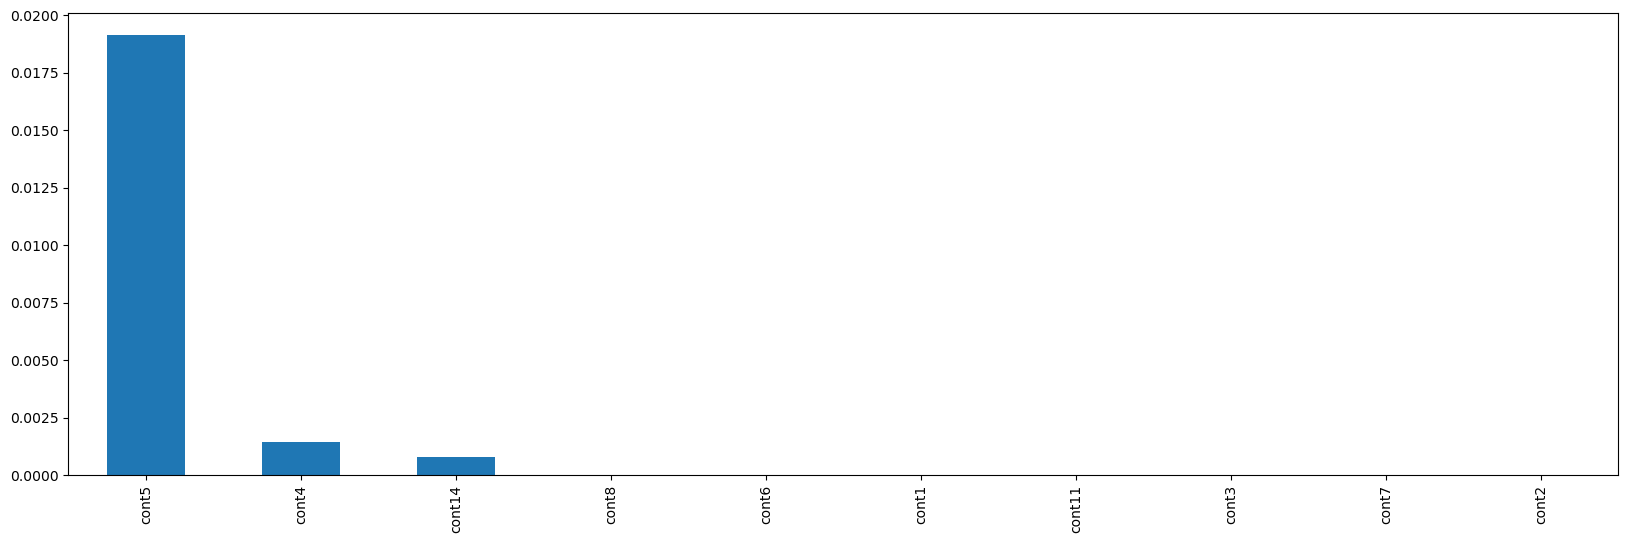

In [28]:
# univariate anova
univariate = f_regression(X_train.fillna(0), y_train)

# plot values
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False).plot.bar(figsize=(20,6))

As we can see the "count 5" feature has the highest linear dependency with the target. Let's drop it

In [29]:
univariate_dict = dict(sorted(univariate.to_dict().items(), key=lambda item: item[1]))

In [30]:
univariate_cols = list(univariate_dict.keys())[-1:]

In [31]:
univariate_cols

['cont5']

In [32]:
X_train.drop(labels=univariate_cols, axis=1, inplace=True)
X_test.drop(labels=univariate_cols, axis=1, inplace=True)

X_train.shape, X_test.shape

((240000, 9), (60000, 9))

In [33]:
### model
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'RMSE: {rmse:.5f}')
#### not a big success, but I'll save this part as an example

RMSE: 0.72721


#### 7. Wrapper

##### 7.1 Exhaustive Feature Selection
Exhaustive Feature Selection finds the best subset of features of all possible feature subsets, according to a determined performance metric for a certain machine learning algorithm.
Using min_features and max_features parameters this algorithm will evaluate all feature combinations. So, for example, if we want to choose a subset with the count of features between 1 to 4 the algorithm will evaluate 15 combinations:
 - all possible combinations of 1 feature
 - all possible combinations of 2 features
 - all possible combinations of 3 features
 - all the 4 features


In [34]:
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [35]:
# exhaustive search
efs = EFS(LinearRegression(), min_features=1, max_features=3, scoring='neg_mean_squared_error', print_progress=True,)
efs = efs.fit(np.array(X_train), y_train)

Features: 129/129

In [36]:
efs.best_idx_

(0, 1, 5)

In [37]:
selected_feat = X_train.columns[list(efs.best_idx_)]
selected_feat

Index(['cont1', 'cont2', 'cont7'], dtype='object')

In [38]:
lr.fit(X_train[selected_feat], y_train)
y_predict = lr.predict(X_test[selected_feat])
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'RMSE: {rmse:.5f}')

RMSE: 0.72839


#### 7.2 Step backward feature selection
Step Backward Feature Selection starts by fitting a model using all features in the data set and determining its performance.

Then, it trains models on all possible combinations of all features -1, and removes the feature that returns the model with the lowest performance.
The algorithm stops on a criteria determined by the user. This criteria could be that the model performance does not decrease beyond a certain threshold, or alternatively, as in the mlxtend implementation, when we reach a certain number of selected features.

In [39]:
# step backward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [40]:
sfs = SFS(LinearRegression(),
          k_features=3, # the lower the features we want, the longer this will take
          forward=False,
          verbose=2,
          scoring='neg_mean_squared_error')

sfs = sfs.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s finished

[2022-10-03 14:03:08] Features: 8/3 -- score: -0.5302260192440877[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s finished

[2022-10-03 14:03:10] Features: 7/3 -- score: -0.5302730688862711[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.3s finished

[2022-10-03 14:03:11] Features: 6/3 -- score: -0.5304792668658923[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [41]:
sfs.k_feature_idx_
## The same result as before, but faster :) 

(0, 1, 5)

#### 8. Regression models
I'm going to fit different regression models to find the best one. For hyperparameters tuning is used GridSearchCV.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.compose import TransformedTargetRegressor

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['target'], axis=1),  # drop the target
    df_train['target'],  # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((240000, 15), (60000, 15))

In [44]:
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)

In [45]:
### 4 different models
models=[
        LinearRegression(),
        Lasso(),
        ElasticNet(),
        Ridge(),
       ]

In [46]:
lasso_params = {'alpha':[0.01, 0.1, 0.5, 1, 5, 10]}

ridge_params = {'alpha': [1, 5, 10, 15] , 
                "fit_intercept": [True, False], 
                "solver": ['svd', 'sag']
               }

elastic_params = {"max_iter": [10000],
                  "alpha": [0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.1, 0.9, 0.1)
                 }

models = {'OLS': GridSearchCV(LinearRegression(),param_grid={}, scoring='neg_mean_squared_error', cv=5),
           'Lasso': GridSearchCV(Lasso(), param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5),
           'Ridge': GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5),
           'Elastic': GridSearchCV(ElasticNet(), param_grid=elastic_params, scoring='neg_mean_squared_error', cv=5)
          }

In [47]:
metrics = pd.DataFrame(columns=['model' , 'best_params', 'best score', 'test rmse',])

In [48]:
def tune(models, X_train, X_test, y_train, y_test, flag_selected=''):
    global metrics
    for i in models:
        clf = models[i]
        clf.fit(X_train, y_train)
        y_pred = clf.best_estimator_.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        print(i)
        print(f'RMSE: {rmse:.5f}')  
        metrics.loc[len(metrics.index)] = [i + ' ' + flag_selected,
                                           clf.best_params_,
                                           clf.best_score_,
                                           rmse
                                          ]

In [49]:
### selected columns from the part below
selected_cols = ['cont1', 'cont2', 'cont7']

In [50]:
tune(models, X_train, X_test, y_train, y_test)
### Also let's check a data set with selected solumns
tune(models, X_train[selected_cols], X_test[selected_cols], y_train, y_test, 'selected')


OLS
RMSE: 0.72552
Lasso
RMSE: 0.73203
Ridge
RMSE: 0.72552
Elastic
RMSE: 0.72678
OLS
RMSE: 0.72839
Lasso
RMSE: 0.73203
Ridge
RMSE: 0.72839
Elastic
RMSE: 0.72883


In [51]:
metrics.sort_values('test rmse')

,model,best_params,best score,test rmse
0,OLS,{},-0.527701,0.725522
2,Ridge,"{'alpha': 10, 'fit_intercept': True, 'solver':...",-0.527701,0.725523
3,Elastic,"{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 1...",-0.529448,0.726784
4,OLS selected,{},-0.531872,0.728391
6,Ridge selected,"{'alpha': 10, 'fit_intercept': True, 'solver':...",-0.531871,0.728391
7,Elastic selected,"{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 1...",-0.532423,0.728832
1,Lasso,{'alpha': 0.01},-0.537070,0.732028
5,Lasso selected,{'alpha': 0.01},-0.537070,0.732028


In [52]:
### I'll try to tune hyperparameters for ridge regression

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['target'], axis=1),  # drop the target
    df_train['target'],  # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((240000, 15), (60000, 15))

In [54]:
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)

In [55]:
parameters = {'alpha': np.arange(5, 15, 1),
              'fit_intercept': [True],
              'solver': ['sag']}
model = Ridge()

# define the grid search
ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=5)

In [56]:
ridge_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'fit_intercept': [True], 'solver': ['sag']},
             scoring='neg_mean_squared_error')

In [57]:
ridge_reg.best_estimator_

Ridge(alpha=9, solver='sag')

In [58]:
# save the model to disk
filename = 'ridge_reg_tuned.sav'
pickle.dump(ridge_reg, open(filename, 'wb'))

In [59]:
mean_squared_error(y_test, ridge_reg.best_estimator_.predict(X_test), squared=False)

0.7255226570203338

In [60]:
df_t = df_val[['id']]
df_val.drop('id', axis=1, inplace=True)
df_t['target'] = ridge_reg.best_estimator_.predict(df_val)
df_t.to_csv("ridge_reg_2.csv", index=False)
###### Kaggle results
#Score: 0.72704
#Public score: 0.72782

C:\Users\Me\AppData\Local\Temp\ipykernel_3816\961455792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['target'] = ridge_reg.best_estimator_.predict(df_val)


In [61]:
df_t.describe()

,id,target
count,200000.000000,200000.000000
mean,250261.031215,7.906009
std,144128.894365,0.099770
min,0.000000,7.374037
25%,125538.250000,7.842406
50%,250389.500000,7.905832
75%,375240.250000,7.969869
max,499990.000000,8.551970


In [62]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(labels=['target'], axis=1),  # drop the target
    df_train['target'],  # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((240000, 15), (60000, 15))

In [77]:
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)

In [46]:
tuned_parameters = {'n_estimators': [500, 750, 1000], 
                     'max_depth': [2, 6, 10]
                    }

In [47]:
rfr = RandomForestRegressor()

In [48]:
random_forest_cv = GridSearchCV(rfr, tuned_parameters, cv=4, scoring='neg_mean_squared_error', verbose=10)
random_forest_cv.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4; 1/9] START max_depth=2, n_estimators=500...............................
[CV 1/4; 1/9] END max_depth=2, n_estimators=500;, score=-0.529 total time= 2.9min
[CV 2/4; 1/9] START max_depth=2, n_estimators=500...............................
[CV 2/4; 1/9] END max_depth=2, n_estimators=500;, score=-0.532 total time= 3.0min
[CV 3/4; 1/9] START max_depth=2, n_estimators=500...............................
[CV 3/4; 1/9] END max_depth=2, n_estimators=500;, score=-0.531 total time= 3.0min
[CV 4/4; 1/9] START max_depth=2, n_estimators=500...............................
[CV 4/4; 1/9] END max_depth=2, n_estimators=500;, score=-0.528 total time= 3.0min
[CV 1/4; 2/9] START max_depth=2, n_estimators=750...............................
[CV 1/4; 2/9] END max_depth=2, n_estimators=750;, score=-0.529 total time= 4.4min
[CV 2/4; 2/9] START max_depth=2, n_estimators=750...............................
[CV 2/4; 2/9] END max_depth=2, n_estimators=

GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 6, 10],
                         'n_estimators': [500, 750, 1000]},
             scoring='neg_mean_squared_error', verbose=10)

In [49]:
random_forest_cv.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=750)

In [50]:
mean_squared_error(y_test, random_forest_cv.best_estimator_.predict(X_test), squared=False)

0.7107028753163503

In [79]:
rf_model = RandomForestRegressor(max_depth=10, n_estimators=750)
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=750)

In [70]:
filename = 'random_forest_reg.sav'
pickle.dump(random_forest_cv.best_estimator_, open(filename, 'wb'))

In [83]:
y_val = rf_model.predict(df_val)

In [90]:
df_val = pd.read_csv('data/test.csv')
df_t = df_val[['id']]
df_val.drop('id', axis=1, inplace=True)
df_t.insert(1, "target", y_val.tolist(), True)
df_t.to_csv("random_forest.csv", index=False)
#Score: 0.71122
#Public score: 0.71255

In [91]:
df_t.describe()

,id,target
count,200000.000000,200000.000000
mean,250261.031215,7.905330
std,144128.894365,0.157343
min,0.000000,7.171000
25%,125538.250000,7.803301
50%,250389.500000,7.887316
75%,375240.250000,7.995759
max,499990.000000,9.093934
